# FINAL PROJECT IN LEARNING ANALYTICS

BY EIRINI MITSOPOULOU & KONSTANTINA PAPADOPOULOU

# Movie Recommender System

Recommender systems have become ubiquitous in our lives. The need to build robust movie recommendation systems is extremely important given the huge demand for personalized content of modern consumers. 

In this project, we attempt to understand the different kinds of recommendation systems and compare their performance on the MovieLens dataset. It includes two of the most commonly used filtering techniques for RS. These are Content–Based Filtering (CBF) and Collaborative Filtering (CF).

In [24]:
# import the needed libraries / modules
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import datetime
from scipy import stats as st
from ast import literal_eval
import statsmodels.formula.api as smf
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

import warnings; warnings.simplefilter('ignore')

In [25]:
# read the movies dataset
metadata = pd.read_csv("movies_metadata.csv")
metadata = metadata[pd.to_numeric(metadata['popularity'], errors='coerce').notnull()]
metadata.drop(metadata.index[19730],inplace=True)
metadata.drop(metadata.index[29502],inplace=True)
metadata.drop(metadata.index[35585],inplace=True)
metadata.id =metadata.id.astype(np.int64)
metadata['popularity'] = metadata['popularity'].astype(float)
metadata.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [28]:
# read the ratings dataset
ratings = pd.read_csv("ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


# Explore data with some basic plots

### PLOT #1: Ratings per user.

Below we present the scatterplot and histogram of ratings number per user.

From the scatterplot we can see the number of ratings given per user id.

Min number of user ratings:  1
Max number of user ratings:  18276


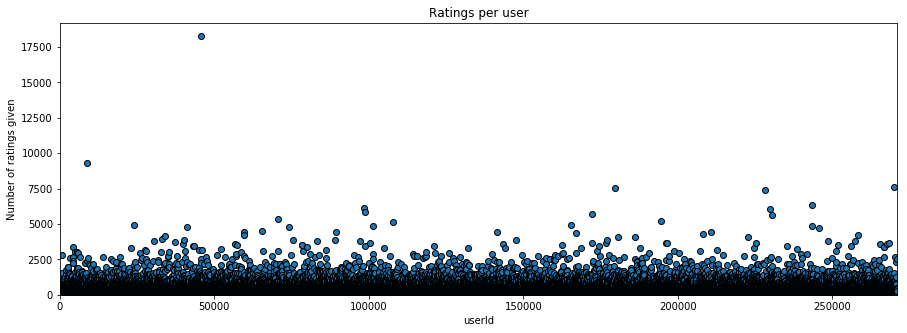

In [69]:
# Scatter plot of all users and individual ratings count.
df_1 = ratings[['userId', 'movieId']].groupby('userId').count()
df_1.columns=['num_ratings']
print("Min number of user ratings: ",min(df_1.num_ratings))
print("Max number of user ratings: ",max(df_1.num_ratings))
plt.figure(figsize=(15,5))
plt.scatter(df_1.index, df_1.num_ratings, edgecolor='black')
plt.xlim(0,len(df_1.index))
plt.ylim(0,)
plt.title('Ratings per user')
plt.xlabel('userId')
plt.ylabel('Number of ratings given')
plt.show()

From the histogram we can see the number of user ids that correspond to each number of ratings given.

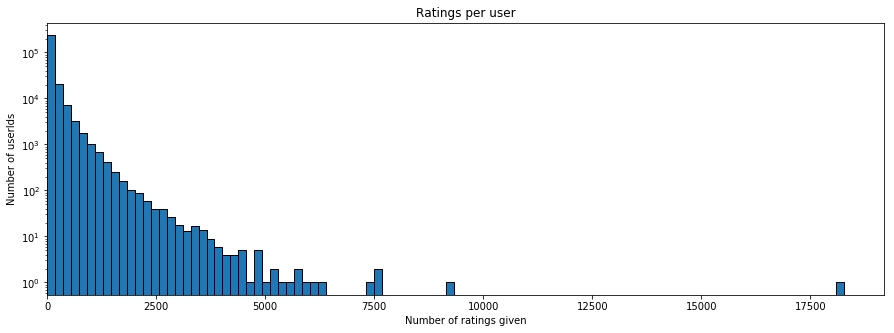

In [70]:
# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(df_1.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Ratings per user')
plt.xlabel('Number of ratings given')
plt.ylabel('Number of userIds')
plt.xlim(0,)
plt.show()

**Conclusions:**

As expected, we get an exponentially declining function, with no users with less than 1 rating given, and some outliers with almost 10.0k and 18.27k ratings.

**Insight:**
These graphs show us how much dedicated are the users to watching and rating movies.

### PLOT #2: Ratings per movie.

Below we present the scatterplot and histogram of ratings number per movie.

From the scatterplot we can see the number of ratings received per movie id.

Mean number of movies' ratings:  576.8433780339134


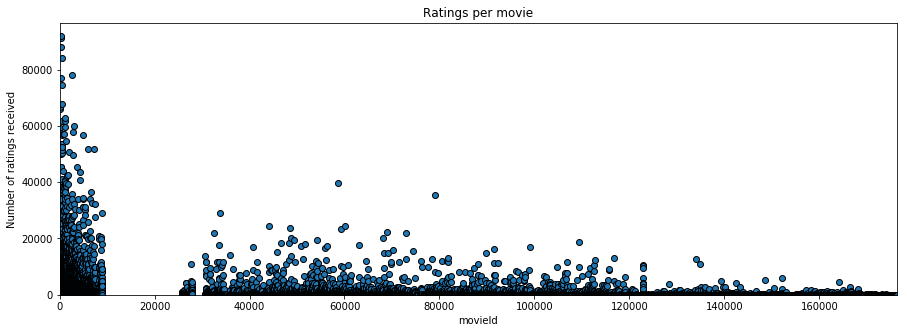

In [71]:
# Scatter plot of all users and individual ratings count.
df_2 = ratings[['userId', 'movieId']].groupby('movieId').count()
df_2.columns=['num_ratings']
print("Mean number of movies' ratings: ",df_2.num_ratings.mean())
plt.figure(figsize=(15,5))
plt.scatter(df_2.index, df_2.num_ratings, edgecolor='black')
plt.xlim(0,df_2.index.max())
plt.ylim(0,)
plt.title('Ratings per movie')
plt.xlabel('movieId')
plt.ylabel('Number of ratings received')
plt.show()

From the histogram we can see the number of movie ids that correspond to each number of ratings received.

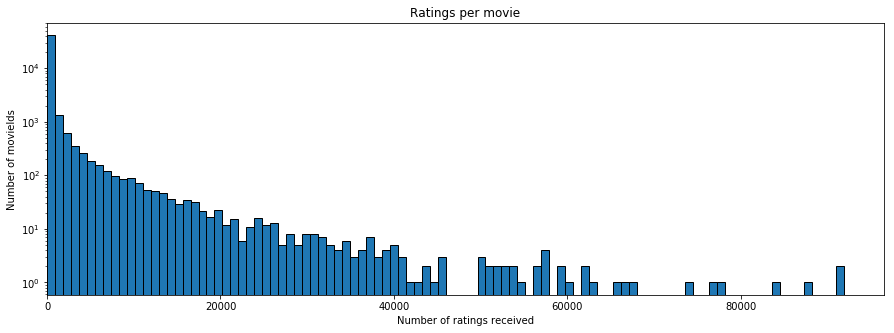

In [72]:
# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(df_2.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Ratings per movie')
plt.xlabel('Number of ratings received')
plt.ylabel('Number of movieIds')
plt.xlim(0,)
plt.show()

**Conclusions:**

From the above we can realize that most movies had a small number of ratings with a mean number of 576.84 ratings per movie. However, the scatterplot presented, also, some outliers over 60000 ratings.

**Insight:** Not many users rate the same movies.

### PLOT #3: Average ratings per year

Let's show the average value of ratings variation in time.

In [73]:
ratings_df = ratings

In [74]:
ratings_df['time_dt'] = ratings_df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))

In [75]:
ratings_df['year'] = ratings_df['time_dt'].dt.year
ratings_df['month'] = ratings_df['time_dt'].dt.month
ratings_df['day'] = ratings_df['time_dt'].dt.day
ratings_df['dayofweek'] = ratings_df['time_dt'].dt.dayofweek

Last year of dataset:  2017


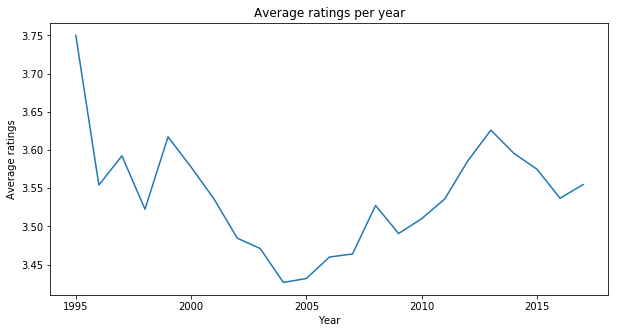

In [76]:
r_df = ratings_df.groupby(['year'])['rating'].mean().reset_index()
print("Last year of dataset: ",max(ratings_df.year))
plt.subplots(ncols=1, figsize=(10,5))
plt.plot(r_df['year'],r_df['rating']); plt.xlabel('Year'); plt.ylabel('Average ratings'); plt.title('Average ratings per year')
plt.show()

**Coclusions:**

We are not observing a special behavior other than variation in time of the ratings averages, with a descending trend from almost 1995 to 1996, also with some peaks in 1995, 1997, 1999, 2008 and 2014 and descending trend since 1999 to 2004, followed by an increase until 2008 and afterwards, an ascending trend from 2009 until 2013 to start decreasing again.

We can say that between 2008 and 2004 the users were not giving big ratings to the movies they were watching.

### PLOT #4: Popular Movies

From the plot below we can find the 10 most popular movies. As we can see the top 1 is the "Minions" movie and the 10th most popular movie is the "Gone Girl".

Text(0.5, 1.0, 'Popular Movies')

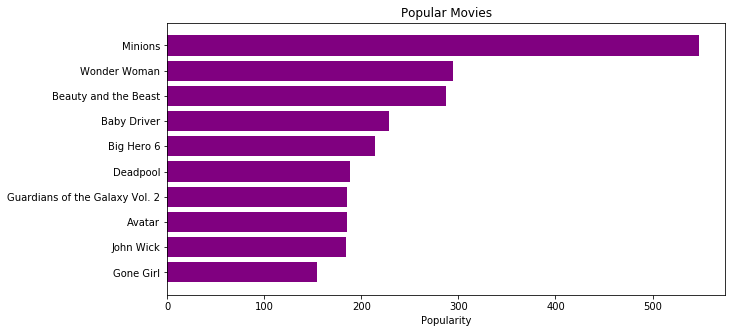

In [14]:
pop= metadata.sort_values('popularity', ascending=False)
plt.figure(figsize=(10,5))

plt.barh(pop['title'].head(10),pop['popularity'].head(10), align='center',color='purple')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

### PLOT #5: Most profitable movie genre using 'revenue' and 'genre' information.

Let's plot the most profitable movie genre using 'revenue' and 'genre' information.

In [15]:
md = pd.read_csv("movies_metadata.csv", dtype='unicode')
# covert each item of release_date to datetime.date type entity
md['release_date'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: x.date())
# all json columns`
json_cols = ['belongs_to_collection', 'genres', 'production_companies', 'production_countries', 'spoken_languages']
for col in json_cols:
    # use ast because json data has single quotes in the csv, which is invalid for a json object; it should be " normally
    md[col] = md[col].apply(lambda x: np.nan if pd.isnull(x) else ast.literal_eval(x))

In [16]:
revOfGenre = {}

for i in range(md.shape[0]):
    for j in md['genres'][i]:
        if 'name' in j and md.iloc[i]['revenue'] is not np.nan:
            name = j['name']
            rev = int(md.iloc[i]['revenue'])/1000000 #store the revenue in million dollars
            if name in revOfGenre:
                revOfGenre[name]['total_revenue'] += rev 
            else:
                revOfGenre[name] = {}
                revOfGenre[name]['genre'] = name
                revOfGenre[name]['total_revenue'] = rev

mostProfitableG = pd.DataFrame(None,None,columns=['genre','revenue'])

for k,v in  revOfGenre.items():
    mostProfitableG =  mostProfitableG.append({'genre':v['genre'],'revenue':v['total_revenue']},ignore_index=True)

In [17]:
 mostProfitableG =  mostProfitableG.sort_values(by='revenue',ascending=False) #Sort by 'revenue'

In [18]:
 mostProfitableG.head()    #Show the first 5 rows

,genre,revenue
7,Action,201456.461294
3,Adventure,200119.343481
1,Comedy,166897.270043
6,Drama,160844.199830
9,Thriller,129821.552609


Most profitable movie genre:  201456.461294
Less profitable movie genre:  42.0


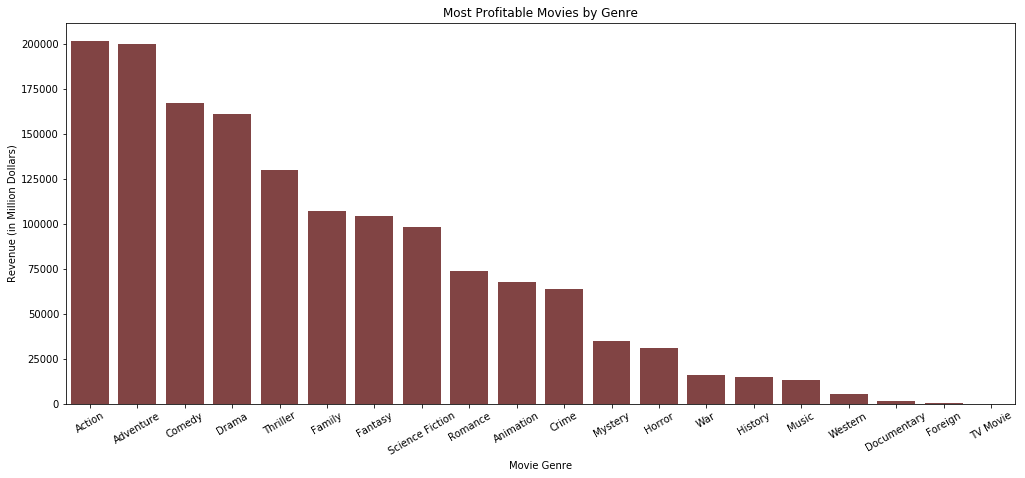

In [19]:
#Plot
plt.figure(figsize=(17,7))
ax = sns.barplot(x= mostProfitableG['genre'], y= mostProfitableG['revenue'], color='#8B3A3A')

print("Most profitable movie genre: ",max( mostProfitableG['revenue']))
print("Less profitable movie genre: ",min( mostProfitableG['revenue']))

x=ax.set_xlabel("Movie Genre")
b=ax.set_ylabel("Revenue (in Million Dollars)")
c=ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=30)
d=ax.set_title("Most Profitable Movies by Genre")

**Conclusions:**

The most profitable movies are the action movies with more than 200k million dollars, followed by the adventure movies with very small difference. The least profitable is the TV Movie genre with 42 million dolars.

### PLOT #6: Most popular genre in terms of popularity points.

We can also plot the most popular genre in terms of popularity points.

In [20]:
md.drop(md.index[35587],inplace=True)    #This row had to be dropped because it contains invalid values.

In [21]:
popularityOfGenre = {}

for i,_ in md.iterrows():
    for j in md['genres'][i]:
        if 'name' in j and md.iloc[i]['popularity'] is not np.nan:
            name = j['name']
            pop = float(md.iloc[i]['popularity'])
            if name in popularityOfGenre:
                popularityOfGenre[name]['total_popularity_points'] += pop 
                popularityOfGenre[name]['total_popularity_counts'] += 1
            else:
                popularityOfGenre[name] = {}
                popularityOfGenre[name]['genre'] = name
                popularityOfGenre[name]['total_popularity_points'] = pop
                popularityOfGenre[name]['total_popularity_counts'] = 0

mostPopularG = pd.DataFrame(None,None,columns=['genre','average_popularity_points'])

for k,v in popularityOfGenre.items():
    mostPopularG =  mostPopularG.append({'genre':v['genre'],'average_popularity_points':v['total_popularity_points']/v['total_popularity_counts']},ignore_index=True)

In [22]:
mostPopularG = mostPopularG.sort_values(by='average_popularity_points',ascending=False)

Most popularity points:  5.800850367095867
Least popularity points:  0.876306290561383


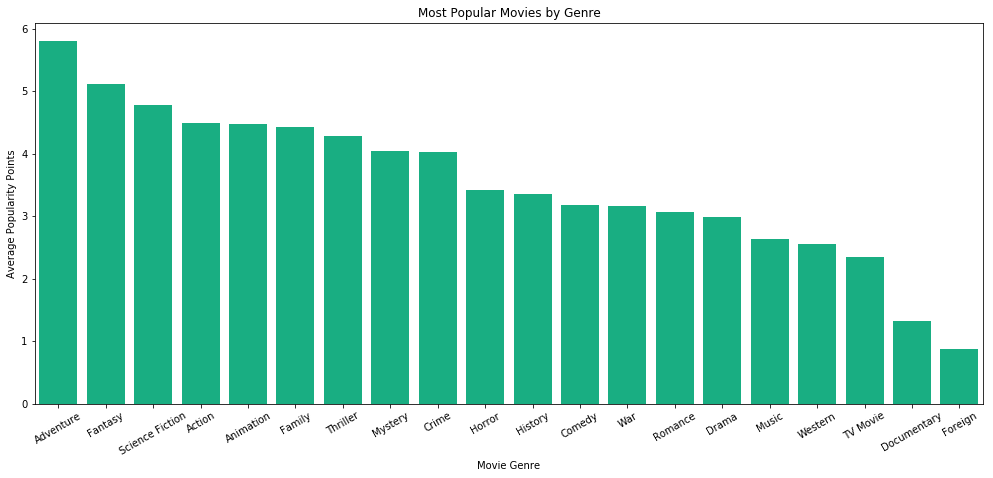

In [23]:
plt.figure(figsize=(17,7))
ax = sns.barplot(x=mostPopularG['genre'],y=mostPopularG['average_popularity_points'],color='#00C78C')

print("Most popularity points: ",max(mostPopularG['average_popularity_points']))
print("Least popularity points: ",min(mostPopularG['average_popularity_points']))

x=ax.set_xlabel("Movie Genre")
b=ax.set_ylabel("Average Popularity Points")
c=ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=30)
d=ax.set_title("Most Popular Movies by Genre")

**Conclusions:**
The most popular movie genre in terms of popularity points is the "Adventure" genre with 5.8 points and the least popular genre is the "Foreign" one with 0.87 points.

### PLOT #7: Average votes for each movie genre.

We can also see average votes for each movie genre.

In [24]:
averageVotesOfG = {}

for i,_ in md.iterrows():
    for j in md['genres'][i]:
        if 'name' in j and md.iloc[i]['vote_average'] is not np.nan:
            name = j['name']
            voteAv = float(md.iloc[i]['vote_average'])
            if name in averageVotesOfG:
                averageVotesOfG[name]['total_votes_points'] += voteAv 
                averageVotesOfG[name]['total_votes_counts'] += 1
            else:
                averageVotesOfG[name] = {}
                averageVotesOfG[name]['genre'] = name
                averageVotesOfG[name]['total_votes_points'] = voteAv
                averageVotesOfG[name]['total_votes_counts'] = 1

highestVotedG = pd.DataFrame(None,None,columns=['genre','average_votes'])

for k,v in averageVotesOfG.items():
    highestVotedG =  highestVotedG.append({'genre':v['genre'],'average_votes':v['total_votes_points']/v['total_votes_counts']},ignore_index=True)

In [25]:
highestVotedG = highestVotedG.sort_values(by='average_votes',ascending=False)

In [26]:
highestVotedG.head()

,genre,average_votes
0,Animation,6.060858
11,History,6.033047
14,War,5.974225
6,Drama,5.868718
8,Crime,5.864801


Highest vote_average:  6.060858324715603
Smallest vore_average:  5.229373368146218


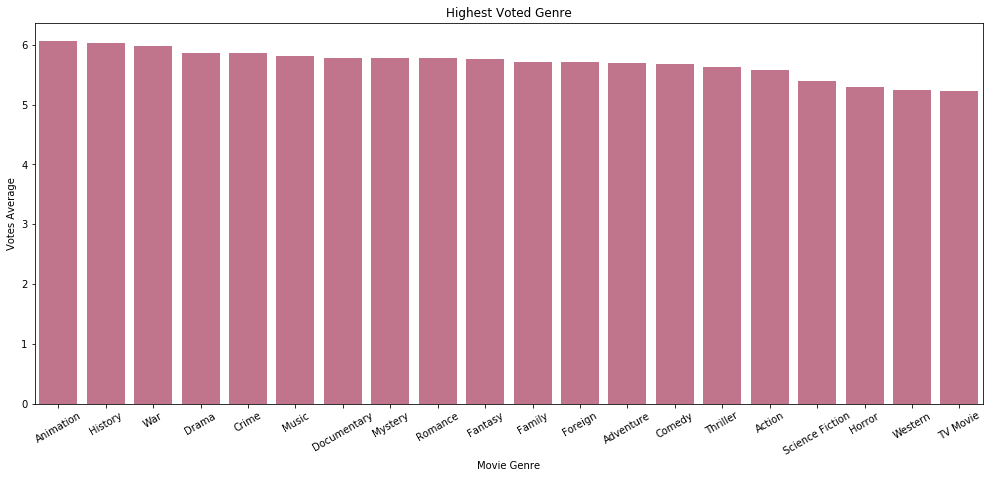

In [27]:
plt.figure(figsize=(17,7))
ax = sns.barplot(x=highestVotedG['genre'], y=highestVotedG['average_votes'], color='#CD6889')

print("Highest vote_average: ",max(highestVotedG['average_votes']))
print("Smallest vore_average: ",min(highestVotedG['average_votes']))

x=ax.set_xlabel("Movie Genre")
b=ax.set_ylabel("Votes Average")
c=ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=30)
d=ax.set_title("Highest Voted Genre")

**Conclusions:**

The highest voted genre is the "Animation" genre with 6.06 in average and the least voted one is the "TV Movie" genre with 5.22 in average. Although, the "Adventure" and the "Action" were the most profitable movie genres and at the top 4 most popular genres, it seems that are not highly voted by the users. 

# Correlation

#### Correlation Map

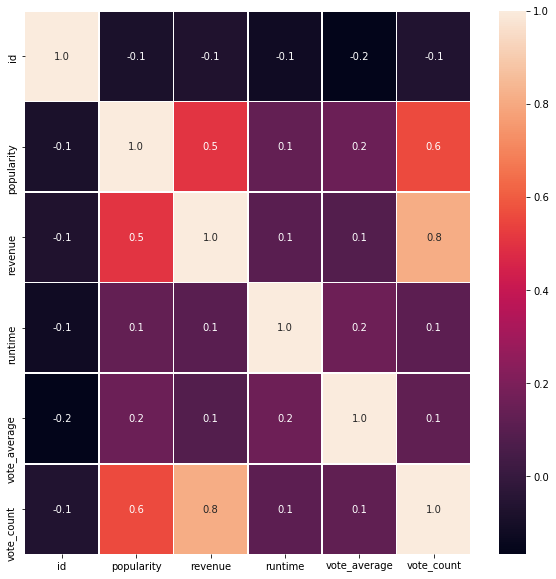

In [93]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(metadata.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

**Conclusions:**

We can see that popularity, revenue and vote_count are correlated. But vote_average is not correlated with them, meaning that the popularity of the movies can result to higher revenue and number of votes but that does not mean that it drives their ratings up.

# Statistical Modelling: Hypothesis Testing

In [19]:
ratings_stats = ratings

#### Choose two sequel movies and take the ratings by users that had rated both the movies

We chose two sequel movies, "Robocop" and "Robocop 2", and we get 23 ratings by the users that rated both of them. Our goal was to observe if there is a significant difference between the two samples, regarding their ratings by the same users.

In [20]:
r1 = ratings_stats.loc[ratings_stats['movieId'] == 5549]    # select the 'Robocop' movie
r2 = ratings_stats.loc[ratings_stats['movieId'] == 5550]    # select the 'Robocop 2' movie
r = pd.merge(r1, r2, on='userId')    # merge the two dataframes in one
r = r[['userId','movieId_x','rating_x','movieId_y','rating_y']]
r

,userId,movieId_x,rating_x,movieId_y,rating_y
0,772,5549,4.0,5550,3.0
1,2372,5549,0.5,5550,0.5
2,8659,5549,3.0,5550,3.0
3,20853,5549,4.0,5550,3.0
4,40576,5549,3.5,5550,3.0
5,46156,5549,3.0,5550,3.0
6,56400,5549,2.5,5550,2.5
7,68586,5549,2.5,5550,2.5
8,73712,5549,3.0,5550,4.0
9,78340,5549,2.5,5550,2.5


#### Present histogram graph for both samples 

Below we present the histograms for the "Robocop" and the "Robocop 2" samples.

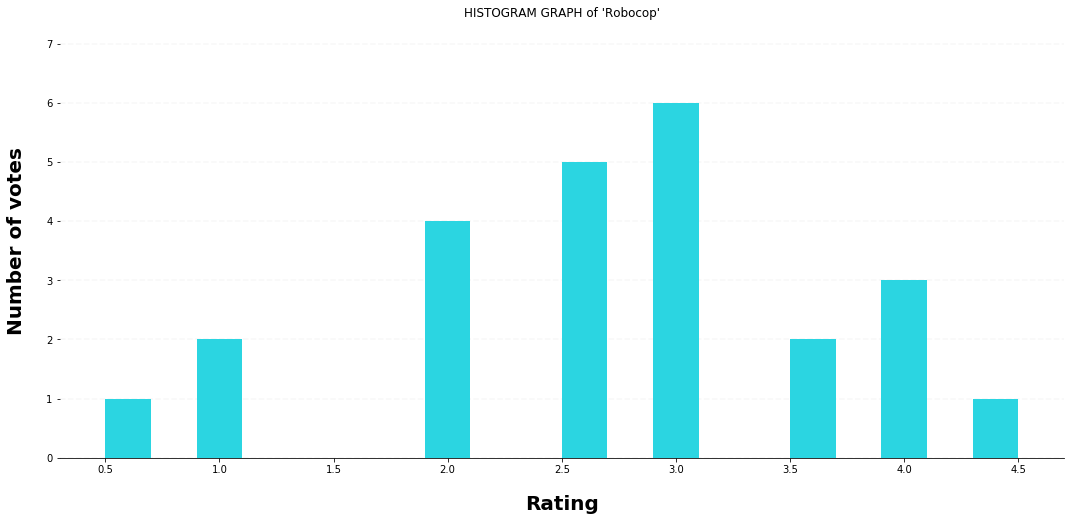

In [21]:
n1 = len(r.rating_x.index)
h1 = r.hist(column='rating_x',align='mid', bins= 20, grid=False, figsize=(18,8),color='#2BD5E1', zorder=2, rwidth=1)
h1 = h1[0]

for x1 in h1:
    
    # Despine
    x1.spines['right'].set_visible(False)
    x1.spines['top'].set_visible(False)
    x1.spines['left'].set_visible(False)
    
    # Draw horizontal axis lines
    vals1 = x1.get_yticks()
    for tick1 in vals1:
        x1.axhline(y=tick1, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
    # Set title
    x1.set_title("HISTOGRAM GRAPH of 'Robocop'")
    
    # Set x-axis label
    x1.set_xlabel("Rating", labelpad=20, weight='bold', size=20)

    # Set y-axis label
    x1.set_ylabel("Number of votes", labelpad=20, weight='bold', size=20)


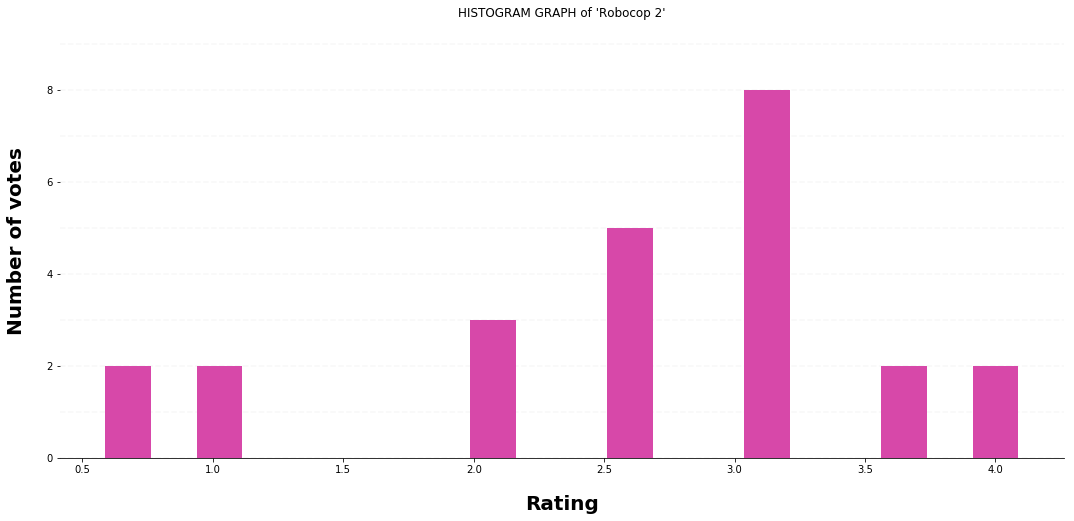

In [22]:
n1 = len(r.rating_y.index)
h1 = r.hist(column='rating_y',align='right', bins= 20, grid=False, figsize=(18,8),color='#D748A9', zorder=2, rwidth=1)
h1 = h1[0]

for x1 in h1:

    # Despine
    x1.spines['right'].set_visible(False)
    x1.spines['top'].set_visible(False)
    x1.spines['left'].set_visible(False)
    
    # Draw horizontal axis lines
    vals1 = x1.get_yticks()
    for tick1 in vals1:
        x1.axhline(y=tick1, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
    # Set title
    x1.set_title("HISTOGRAM GRAPH of 'Robocop 2'")
    
    # Set x-axis label
    x1.set_xlabel("Rating", labelpad=20, weight='bold', size=20)

    # Set y-axis label
    x1.set_ylabel("Number of votes", labelpad=20, weight='bold', size=20)


We can observe that the distribution of the graphs that the first graph seems normal whereas the second one does not seem normal. So, we can expect that the second graph will not conform to the normality criterion check below.

#### Exploring the correlation between the two samples and presenting scatterplot graph


                  PEARSON CORRELATION BETWEEN SAMPLES
----------------------------------------------------------------------------

Correlation coefficient r =  0.7688113035094101




              userId  movieId_x  rating_x  movieId_y  rating_y
userId     1.000000        NaN -0.092694        NaN  0.032190
movieId_x       NaN        NaN       NaN        NaN       NaN
rating_x  -0.092694        NaN  1.000000        NaN  0.768811
movieId_y       NaN        NaN       NaN        NaN       NaN
rating_y   0.032190        NaN  0.768811        NaN  1.000000


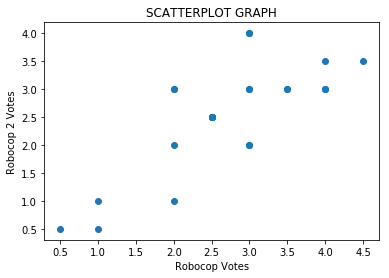

In [23]:
print("\n                  PEARSON CORRELATION BETWEEN SAMPLES")
print("----------------------------------------------------------------------------\n")
cor, p = st.pearsonr(r["rating_x"],r["rating_y"])
print("Correlation coefficient r = ",cor)

print("\n\n\n\n",r.corr())
plt.scatter(r["rating_x"],r["rating_y"])
plt.xlabel("Robocop Votes")
plt.ylabel("Robocop 2 Votes")
plt.title("SCATTERPLOT GRAPH")
plt.show()

In order to explore the correlation between these two samples we used the scipy.stats.pearsonr(x, y) method from which we get that the coefficient between the two samples is positive, meaning that correlation slopes upward, but, it is also strong as well, because the absolute value of the coefficient ≈ 0.77. 

**Conclusion:** There is a strong and positive correlation between the two samples. 

Below we will explore whether the two means of the two related samples are significantly different, regarding their ratings by the same users. 

**IV (Independent Variable):** The movies that the users rated with two conditions: (a) movie "Robocop", (b) movie "Robocop 2"

**DV (Dependent Variable):** The ratings

**Population:** 23 users that rated both of the movies

**Null hypothesis:** H0 = There is no significant difference in a user's rating for the "Robocop" and the "Robocop 2" movie.

The first step when applying statistical controls is to check the normality and variance criteria

**Check data for normality criterion**

To test for normality, we applied the Shapiro-Wilk test by calling the scipy stats.shapiro() method.
This control tests the null hypothesis that the data was drawn from a normal distribution and returns the test statistic ('W') and the probability ('p').

In [33]:
p1 = round(st.shapiro(r.rating_x.dropna())[1],4)
p2 =  round(st.shapiro(r.rating_y.dropna())[1],4)
print('Normality control probability p for "Robocop": ',p1)
print('Normality control probability p for "Robocop 2": ',p2)
if p1>0.05 and p2>0.05:
    print("\nConclusion: Since p > 0.05 for one or both of the samples, we can not say that  both of them  conform to the normality criterion")
else:
    print("\nConclusion: Since p < 0.05 for one or both of the samples, we can not say that  both of them  conform to the normality criterion")

Normality control probability p for "Robocop":  0.3759
Normality control probability p for "Robocop 2":  0.0236

Conclusion: Since p < 0.05 for one or both of the samples, we can not say that  both of them  conform to the normality criterion


**Check data for variance criterion**

To test for variance, we apply the Levene test by calling the scipy stats.levene() method.
This control tests the null hypothesis that all samples come from populations with equal variances. It returns the test statistic ('W') and the probability ('p').

In [34]:
# Levene variance test for Control and Treatment groups 
p = st.levene(r.rating_x.dropna(), r.rating_y.dropna())[1]
print('Between Group Variance: p =', p)
if p>0.05:
    print("\nConclusion: As p > 0.05 the samples conform to the variance criterion")

Between Group Variance: p = 0.8232011687036676

Conclusion: As p > 0.05 the samples conform to the variance criterion


When the normality criterion is violated (samples do not come from normal distributions) then non-parametric statistical control should be applied.

Non-parametric statistics are a branch of statistics making no assumptions about the probability distributions of the variables.

**Since the normality criterion is rejected, we proceed with the corresponding non-parametric test, the Wilcoxon signed-rank test to check for significant difference between the groups**.

Wilcoxon signed-rank test is the non-parametric counterpart of the paired t-test. We apply the Wilcoxon signed-rank test by calling the scipy stats.wilcoxon() method.

In [35]:
w , p= st.wilcoxon(r.rating_x.dropna(), r.rating_y.dropna())
print("Wilcoxon signed-rank test: W = ", w, ",   p-value = " , p )
if p<=0.05:   
    print("\nSince p < a (0.05), the null hypothesis is rejected!")
else:
    print("\nSince p > a (0.05), the null hypothesis is accepted!")
print("\"Robocop\" mean = ", r.rating_x.dropna().mean(),",  \"Robocop 2 mean\" = ",r.rating_y.dropna().mean())

Wilcoxon signed-rank test: W =  38.0 ,   p-value =  0.3409812623376832

Since p > a (0.05), the null hypothesis is accepted!
"Robocop" mean =  2.6875 ,  "Robocop 2 mean" =  2.5208333333333335


**Interpretation of results**

The p value returned (0.34) is higher than threshold 'a' (0.05). Thus the null hypothesis is accepted and we argue that "Robocop" rating is not significantly different compared to the "Robocop 2" rating by the users.

# Predictive modelling: Regression 

### Explore whether "Robocop" ratings sample is a predictor of "Robocop 2" ratings sample

#### Implement Regression Model 

In [14]:
# Split data for training [:18] and testing [18:]
rob2_train = r['rating_y'].iloc[:18]
rob1_train = r['rating_x'].iloc[:18]

rob2_test = r['rating_y'].iloc[18:]
rob1_test = r['rating_x'].iloc[18:]

# Set training data as DataFrame df
# Set predictor x as Independent var and Output y as dependent var
df = r[['rating_y','rating_x']].iloc[:18]
x = rob1_train 
y = rob2_train 

# Fit the model 
model = smf.ols(formula='y ~ x', data=df).fit()

# print params and summary 
print(model.params)
print(model.summary())

# predict
print('\nPrediction\n')
ypred = model.predict({'x': rob1_test}) 
print(ypred)

Intercept    0.272189
x            0.810651
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     36.31
Date:                Sun, 16 Jun 2019   Prob (F-statistic):           1.76e-05
Time:                        12:26:01   Log-Likelihood:                -14.768
No. Observations:                  18   AIC:                             33.54
Df Residuals:                      16   BIC:                             35.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

Step 1) Analyzing the correlation of the data: We need to examine if there is correlation between "Robocop" ratings sample and  "Robocop 2" ratings sample. Pearson correlation coefficient is r~0.77. That means that there is a high positive correlation between "Robocop" ratings sample and "Robocop 2" ratings sample.

Step 2) Estimating predictive analysis: We implement linear regression model in order to find out if "Robocop" ratings sample is a predictor of "Robocop 2" ratings sample. So, the dependent variable is "Robocop 2" ratings sample matrix of row-vectors and the independent variable is "Robocop" ratings sample matrix of row-vectors. Our dataframe is 23 rows, so we split data in 18 rows of training data and 5 rows of testing data. We fit the linear regression model is our training data and by using the predict method, we compute the predicted values of our test data.

Step 3) Evaluating the validity and usefulness of the model: By taking a look at OLS Regression Results summary table R-squared (coefficient of determination) is interpreted as the proportion of the variance in the dependent variable that is predictable from the independent variable and it ranges from 0 to 1. In our case R-squared = 0.69 means fitted model showed ~ 69% reduction in error over null model. At the same time, Prob (F-statistic) is the probability that the relationship between dependent and independent variable is occurring by chance. Prob (F-statistic) = 1.76e-05 implies that there is statistically significant relationship between "Robocop" ratings sample and  "Robocop 2" ratings sample (using p < 0.05 as a rejection rule).

##### Conslusion: "Robocop" ratings sample is a predictor of "Robocop 2" ratings sample.

# Top Rated Movies Chart according to IMDB's weighted rating formula

The Internet Movie Database (IMDB) maintains a chart called the IMDB Top 250, which is a ranking of the top 250 movies according to a certain weighted rating formula.

We will use the TMDB Ratings to come up with a Top Movies Chart. We will use IMDB's weighted rating formula to construct a chart. This formula provides a true 'Bayesian estimate', which takes into account the number of votes each title has received, minimum votes required to be on the list, and the mean vote for all titles 

Weighted Rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C where, 

* v is the number of votes for the movie
* m is the minimum votes required to be listed in the chart
* R is the average rating of the movie
* C is the mean vote across the whole report

In [13]:
C= metadata['vote_average'].mean()
C

5.618168818883486

So, the mean rating for all the movies is approx 6 on a scale of 10.The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 95th percentile as our cutoff. 

In [14]:
m = metadata['vote_count'].quantile(0.95)
m

433.1999999999971

In [15]:
qualified = metadata.copy().loc[metadata['vote_count'] >= m]
qualified.shape

(2273, 26)

We see that there are 2273 movies which qualify to be in this list. Now, we need to calculate our metric for each qualified movie. To do this, we will define a function, weighted_rating() and define a new feature wr, of which we'll calculate the value by applying this function to our DataFrame of qualified movies.

In [16]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [17]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [18]:
qualified[['title','vote_count', 'vote_average','popularity', 'wr']].head(10)

,title,vote_count,vote_average,popularity,wr
314,The Shawshank Redemption,8358.0,8.5,51.645403,8.357993
834,The Godfather,6024.0,8.5,41.109264,8.306664
12481,The Dark Knight,12269.0,8.3,123.167259,8.208538
2843,Fight Club,9678.0,8.3,63.869599,8.185101
292,Pulp Fiction,8670.0,8.3,140.950236,8.172378
351,Forrest Gump,8147.0,8.2,48.307194,8.069648
522,Schindler's List,4436.0,8.3,41.725123,8.061404
23670,Whiplash,4376.0,8.3,64.299990,8.058428
5481,Spirited Away,3968.0,8.3,41.048867,8.036034
1154,The Empire Strikes Back,5998.0,8.2,19.470959,8.026090


This chart can be considered the simplest of recommenders. It doesn’t take into consideration the tastes of a particular user nor does it try to deduce similarities between different movies. It simply calculates a score for every movie based on a predefined weighted rating formula and outputs a sorted list of movies based on that formula.

# Content Based Filtering

The Content-Based Recommender relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. So, this is an engine that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked. 

It generally works well when it's easy to determine the context/properties of each item. Most of the recommendation system works with information in text form such as news, books and documents.

The content in this system usually uses keywords and the significance of a keyword is measured by TFIDF weight. It denotes the frequency of occurrence of the keyword in the document where as IDF is inverse document frequency of the keyword.

## Content Based Recommender based on Movie Overviews and Taglines

We have to just convert the words or text in vector form and to find the closest recommendation to our given movie input title using cosine similarity.

#### We will build a recommender using movie descriptions and taglines. 

In [19]:
metadata['tagline'] = metadata['tagline'].fillna('')
metadata['description'] = metadata['overview'] + metadata['tagline']
metadata['description'] = metadata['description'].fillna('')

#### We define a TF-IDF Vectorizer Object. First, we remove all english stop words such as 'the', 'a'.
TF is simply the frequency of a word in a document. IDF is the inverse of the document frequency among the whole corpus of documents. TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

We will use TfidfVectorizer function from scikit-learn, which transforms text to feature vectors that can be used as input to estimator.

In [20]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(metadata['description'])

After calculating TF-IDF scores, how do we determine which items are closer to each other, rather closer to the user profile?
We need a relative measure.

The method of calculating this relative measure is calculated by taking the cosine of the angle between the sentences and the terms. The ultimate reason behind using cosine is that the value of cosine will increase with decreasing value of the angle between which signifies more similarity.

#### Cosine Similarity

We will be using Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Therefore, we will use sklearn's linear_kernel functon.

In [21]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
metadata = metadata.reset_index()
titles = metadata['title']
indices = pd.Series(metadata.index, index=metadata['title'])

We now have a pairwise cosine similarity matrix for all the movies in the dataset. The next step is to write a function that returns the 10 most similar movies based on the cosine similarity score.

#### Implement a function that returns the 10 most similar movies based on the cosine similarity score.

In [22]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    recommendations = metadata.iloc[movie_indices][['title', 'vote_average']]
    return recommendations

In [23]:
get_recommendations('Batman Returns')

,title,vote_average
25264,Batman vs Dracula,6.5
15511,Batman: Under the Red Hood,7.6
21191,Batman Unmasked: The Psychology of the Dark Kn...,8.0
18252,The Dark Knight Rises,7.6
41973,Batman Beyond Darwyn Cooke's Batman 75th Anniv...,7.7
41967,The Lego Batman Movie,7.2
40965,LEGO DC Comics Super Heroes: Batman: Be-Leaguered,6.1
40937,Batman: Return of the Caped Crusaders,7.2
20229,"Batman: The Dark Knight Returns, Part 2",7.9
3095,Batman: Mask of the Phantasm,7.4


In [24]:
get_recommendations('Superman Returns')

,title,vote_average
32244,Atom Man vs Superman,3.8
2529,Superman IV: The Quest for Peace,4.1
2527,Superman II,6.5
30817,Superman: Brainiac Attacks,6.1
16626,All Star Superman,6.8
9169,The Batman Superman Movie: World's Finest,7.1
19063,Superman/Batman: Public Enemies,6.7
21121,Lego Batman: The Movie - DC Super Heroes Unite,6.4
2526,Superman,6.9
24560,Generation War,8.2


## Content Based Recommender based on Movie Overviews, Taglines and Ratings as well
One thing that we notice about our recommendation system is that it recommends movies regardless of ratings and popularity. Therefore, we will add a mechanism to remove bad movies and return movies with high vote count and high vote average.

We will take the top 25 movies based on similarity scores and calculate the vote of the 60th percentile movie. Then, using this as the value of  m, we will calculate the weighted rating of each movie.

In [25]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = metadata.iloc[movie_indices][['title', 'vote_count', 'vote_average']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    recommendations = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    recommendations['vote_count'] = recommendations['vote_count'].astype('int')
    recommendations['vote_average'] = recommendations['vote_average']
    recommendations['wr'] = recommendations.apply(weighted_rating, axis=1)
    recommendations = recommendations.sort_values('wr', ascending=False).head(10)
    return recommendations

In [26]:
get_recommendations('Batman Returns')

,title,vote_count,vote_average,wr
12481,The Dark Knight,12269,8.3,8.208538
18252,The Dark Knight Rises,9263,7.6,7.511457
41967,The Lego Batman Movie,1473,7.2,6.840516
20229,"Batman: The Dark Knight Returns, Part 2",426,7.9,6.749524
15511,Batman: Under the Red Hood,459,7.6,6.637739
19789,"Batman: The Dark Knight Returns, Part 1",410,7.7,6.630444
1110,The Wrong Trousers,266,7.6,6.372126
23875,Batman: Assault on Arkham,298,7.3,6.303598
18218,Happy Feet Two,381,5.8,5.703256
150,Batman Forever,1529,5.2,5.292320


In [27]:
get_recommendations('Superman Returns')

,title,vote_count,vote_average,wr
20229,"Batman: The Dark Knight Returns, Part 2",426,7.9,6.749524
2526,Superman,1042,6.9,6.523584
2527,Superman II,642,6.5,6.144709
226,Dolores Claiborne,183,7.1,6.058245
21469,Justice League: Crisis on Two Earths,152,7.1,6.003060
19063,Superman/Batman: Public Enemies,158,6.7,5.907291
16626,All Star Superman,121,6.8,5.876201
19030,Superman: Doomsday,138,6.5,5.831216
2528,Superman III,500,5.3,5.447697
2529,Superman IV: The Quest for Peace,327,4.1,4.965129


**Pros** of using content-based recommendation:
* Can recommend to users with unique tastes.
* Can recommend new items.
* The user gets recommended the types of items they love.

**Cons** of using content-based recommendation:
* Finding the appropriate features is hard.
* Unable to exploit quality judgments of other users.
* The user will never be recommended for different items.
* Business cannot be expanded as the user does not try a different type of product.

# Nearest Neighbors Collaborative Filtering

Collaborative Filtering techniques make recommendations for a user based on ratings and preferences data of many users. The main underlying idea is that if two users have both liked certain common items, then the items that one user has liked that the other user has not yet tried can be recommended to him. We see collaborative filtering techniques in action on various Internet platforms such as Amazon.com, Netflix, Facebook. We are recommended items based on the ratings and purchase data that these platforms collect from their user base.

Nearest Neighbors Collaborative Filtering: This approach relies on the idea that users who have similar rating behaviors so far, share the same tastes and will likely exhibit similar rating behaviors going forward. The algorithm first computes the similarity between users by using the row vector in the ratings matrix corresponding to a user as a representation for that user. The similarity is computed by using cosine similarity. In order to predict the rating for a particular user for a given movie j, we find the top k similar users to this particular user and then take a weighted average of the ratings of the k similar users with the weights being the similarity values.

In [5]:
new_ratings = pd.merge(ratings,metadata[['title','id']],left_on='movieId',right_on='id')
new_ratings.head()

,userId,movieId,rating,timestamp,title,id
0,1,110,1.0,1425941529,Three Colors: Red,110
1,11,110,3.5,1231676989,Three Colors: Red,110
2,22,110,5.0,1111937009,Three Colors: Red,110
3,24,110,5.0,979870012,Three Colors: Red,110
4,29,110,3.0,1044020005,Three Colors: Red,110


Create the Ratings Matrix, where the columns represent all the movies and each row vectors represents each user's rating in terms of all the movies. Cells filled with 0.0 means that user has never voted for this certain movie.

In [8]:
if not new_ratings[new_ratings.duplicated(['userId','title'])].empty:
    new_ratings = new_ratings.drop_duplicates(['userId','title'])
df_for_knn = new_ratings.pivot(index='userId',columns='title',values='rating').fillna(0)
df_for_knn.head()

title,!Women Art Revolution,"$1,000 on the Black",$5 a Day,'Gator Bait,'R Xmas,'Twas the Night Before Christmas,(A)Sexual,...And God Created Woman,...And the Pursuit of Happiness,00 Schneider - Jagd auf Nihil Baxter,...,¡A volar joven!,¡Three Amigos!,À nos amours,Åke and His World,Æon Flux,Ödipussi,Şaban Oğlu Şaban,Škola princů,Šíleně smutná princezna,Львиная доля
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Fast computation of nearest neighbors is an active area of research in machine learning. The most naive neighbor search implementation involves the brute-force computation of distances between all pairs of points in the dataset.

We implement the KNN algorithm that computes the similarity between users by using the row vector in the ratings matrix corresponding to a user as a representation for that user. Algorithm used to compute the nearest neighbors  will use a brute-force search. The similarity is computed by using cosine similarity.

In [11]:
df_for_knn_sparse = csr_matrix(df_for_knn.values)
model_knn = NearestNeighbors(metric='cosine',algorithm='brute')
model_knn.fit(df_for_knn_sparse) 

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

Then, we get the top k similar users to this particular user along with their distance values. Remember: the smallest the distance value is the more similar the two users are.

In [12]:
userid = 120
n_neighbors = 11 # for top 10 (the first is the user itself)
distances, indices = model_knn.kneighbors(df_for_knn.loc[userid].values.reshape(1,-1),n_neighbors=11) # get the top k similar users to this particular user
print("Nearest Neighbors of User with ID = {0}:".format(userid))
for i in range(0,len(distances.flatten())):
    if i!=0: # avoid the first user that is the user itself
        print("{0}: UserId: {1} -- Distance: {2}".format(i,df_for_knn.index[indices.flatten()[i]],distances.flatten()[i])) 

Nearest Neighbors of User with ID = 120:
1: UserId: 79091 -- Distance: 0.4358862071111006
2: UserId: 48329 -- Distance: 0.4399554612891232
3: UserId: 170179 -- Distance: 0.4451046099840349
4: UserId: 165164 -- Distance: 0.4460073130464167
5: UserId: 151656 -- Distance: 0.4479670049842581
6: UserId: 14127 -- Distance: 0.45085036889186847
7: UserId: 249319 -- Distance: 0.4533490133003407
8: UserId: 6893 -- Distance: 0.45566191969954795
9: UserId: 80096 -- Distance: 0.45597422711617475
10: UserId: 100589 -- Distance: 0.45815050773907007


In order to predict the rating for a particular user for a given movie j, we compute a weighted average of the ratings of the k similar users with the weights being the similarity values. We assumed that similarity = 1 - distance.

In [13]:
sum = 0
weightsum = 0
movie = 'Batman Returns' # the movie we'll try to predict the rating 
for i in range(0,len(distances.flatten())):
    if i!=0:
        indice = df_for_knn.index[indices.flatten()[i]]
        weight = 1 - distances.flatten()[i] # computes the weights according to the similarity
        sum = sum + df_for_knn.loc[indice, movie]*weight # computes the weighted sum
        weightsum = weightsum + weight
print ("The rating that the user with ID = {0} will give in the movie {1} is: {2}".format(userid,movie,round(sum/weightsum,1)))

The rating that the user with ID = 120 will give in the movie Batman Returns is: 3.4


Cons of using Nearest Neighbors Collaborative Filtering:

It suffers issues such as sparsity, cold start and scalability problem.
* Sparsity: Ιts a very common problem which usually observed, when a user do not prefer to give feedback or like dislike any item. This creates a difficulty in finding nearest neighbor or similar user, according to which the system makes recommendation.
* Cold start: it appears in the early stages of a system or  when new users or items that don't have any ratings enter the system.
* Scalability and big data: as the no of users and items are rapidly increasing so the load on the system is also increasing simultaneously. Large datasets acquires more time to process, to extract information which compromises the quality, processing time of the recommender system.



### REFERENCES:
PAPERS

1. Sappadla, Prateek, Yash Sadhwani, and Pranit Arora. “Movie Recommender System.” Search Engine Architecture, Spring 2017, NYU Courant, (n.d.): 5.

2.  Kalra, Nupur, Deepak Yadav, and Gourav Bathla. “Movie Recommender System Using Collaborative Filtering.” International Journal on Future Revolution in Computer Science & Communication Engineering, 4, no. 12 (n.d.): 5, December 2018.

3. Arefin, Ahmed Shamsul, Carlos Riveros, Regina Berretta, and Pablo Moscato. “GPU-FS-KNN: A Software Tool for Fast and Scalable KNN Computation Using GPUs.” Edited by Alexandre G. de Brevern. PLoS ONE7, no. 8 (August 28, 2012): e44000.

WEBSITES

1. https://grouplens.org/datasets/movielens/
2. https://towardsdatascience.com/brief-on-recommender-systems-b86a1068a4dd

### EXAMPLES OF WEBSITES THAT USE OUR RECOMMENDER SYSTEMS:
- https://www.netflix.com/browse

- https://www.imdb.com/?ref_=nv_home

- https://openlibrary.org/
